In [1]:
print(__doc__)

# Common imports
import numpy as np
import numpy.random as rnd
import os
import pandas as pd

# File specific imports
import datetime
from dateutil.relativedelta import relativedelta

# To make this notebook's output stable across runs
rnd.seed(42)

# Show all columns when displaying dataframes
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

Automatically created module for IPython interactive environment


In [2]:
csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/ADMISSIONS.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_LOCATION', 'ETHNICITY', 'DIAGNOSIS']
admissions = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/PATIENTS.csv'
cols_to_keep = ['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']
patients = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/INPUTEVENTS_CV.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM'] # 'RATE', 'RATEUOM', 'STOPPED' are full of NaN
inputevents_cv = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/INPUTEVENTS_MV.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME', 'ENDTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'RATE', 'RATEUOM', 'ORDERCATEGORYNAME', 'ORDERCATEGORYDESCRIPTION']
inputevents_mv = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/LABEVENTS.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM', 'FLAG'] # 'HADM_ID' is full of NaN
labevents = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/D_ITEMS.csv'
cols_to_keep = ['ITEMID', 'LABEL'] #'CATEGORY', 'UNITNAME', 'PARAM_TYPE' are full of NaN
d_items = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/D_LABITEMS.csv'
cols_to_keep = ['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']
d_labitems = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
admissions = admissions.applymap(str)
patients = patients.applymap(str)
inputevents_cv = inputevents_cv.applymap(str)
inputevents_mv  = inputevents_mv .applymap(str)
labevents  = labevents.applymap(str) 
d_items = d_items.applymap(str)
d_labitems = d_labitems.applymap(str)

# PATIENT INFORMATION

In [4]:
# Combine admissions and patients
patient_info = pd.merge(admissions, patients, on = ['SUBJECT_ID'])

# Change Ethnicity to White/Non-White
ethnicity = patient_info['ETHNICITY']

def get_ethnicity(value):
    if value == 'WHITE':
        return 'WHITE'
    else:
        return 'NOT WHITE'

list_ethnicity = [get_ethnicity(value) for value in ethnicity]

patient_info = patient_info.drop('ETHNICITY', axis = 1)
df_ethnicity = pd.DataFrame({'ETHNICITY' : list_ethnicity})
patient_info = pd.concat([patient_info, df_ethnicity], axis=1)

# Add ages
DoB = patient_info['DOB']
admDate = patient_info['ADMITTIME']

def get_age (birth, current):
    #replace dashes and colons with spaces to make breaking the string up easier
    birth = birth.replace('-', ' ')
    birth = birth.replace(':', ' ')
    current = current.replace('-', ' ')
    current = current.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    birth = birth.split(' ')
    current = current.split(' ')

    #convert to integers
    birth = [int(i) for i in birth]
    current = [int(i) for i in current]
    
    #get age and return it
    birth = datetime.datetime(birth[0], birth[1], birth[2], birth[3], birth[4], birth[5])
    current = datetime.datetime(current[0], current[1], current[2], current[3], current[4], current[5])
    age = relativedelta(current, birth).years
    
    #adjust for 89+ category
    if age == 300:
        age = 89
    
    return age

def get_age_category(age):
    if age > 88:
        return ('89+')
    elif age > 60:
        return('Elderly')
    elif age > 50:
        return('50s')
    elif age > 40:
        return('40s')
    elif age > 30:
        return('30s')
    elif age > 17:
        return('20s')
    else:
        return('Child')

ages = []
age_categories = []

for i in range(len(DoB)):
    ages.append(get_age(DoB[i], admDate[i]))

for age in ages:
    age_categories.append(get_age_category(age))

ages_df = pd.DataFrame({'AGE' : ages})
ages_cat_df = pd.DataFrame({'AGE_CAT' : age_categories})
patient_info = pd.concat([patient_info, ages_df], axis=1)
patient_info = pd.concat([patient_info, ages_cat_df], axis=1)

# Add LOS
admDate = patient_info['ADMITTIME']
dischDate = patient_info['DISCHTIME']

def get_los (admit, disch):
    #replace dashes and colons with spaces to make breaking the string up easier
    admit = admit.replace('-', ' ')
    admit = admit.replace(':', ' ')
    disch = disch.replace('-', ' ')
    disch = disch.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    admit = admit.split(' ')
    disch = disch.split(' ')

    #convert to integers
    admit = [int(i) for i in admit]
    disch = [int(i) for i in disch]
    
    #get los and return it
    admit = datetime.datetime(admit[0], admit[1], admit[2], admit[3], admit[4], admit[5])
    disch = datetime.datetime(disch[0], disch[1], disch[2], disch[3], disch[4], disch[5])
    los = (disch-admit).total_seconds()/3600
    los = round((los/24), 1)

    return los

los = []

for i in range(len(admDate)):
    los.append(get_los(admDate[i], dischDate[i]))
    
los_df = pd.DataFrame({'LOS' : los})
patient_info = pd.concat([patient_info, los_df], axis = 1)

# Get Day/Night (day is between 8 am : 8 pm)
admTime = patient_info['ADMITTIME']

def get_day_night (value):
    #replace dashes and colons with spaces to make breaking the string up easier
    value = value.replace('-', ' ')
    value = value.replace(':', ' ')
    
    #split into a string outputting [year, month, day, hour, minutes, seconds]
    date = value.split(' ')
    
    #leave hour/min/sec, convert to integers
    hour = date[3]
    int_hour = int(hour)
    
    #get day/night and return it
    if 7 < int_hour < 21:
        return 'DAY'
    else:
        return 'NIGHT'

day_night = [get_day_night(value) for value in admTime]

day_night_df = pd.DataFrame({'DAY_NIGHT' : day_night})
patient_info = pd.concat([patient_info, day_night_df], axis=1)

# Get admission day
admTime = patient_info['ADMITTIME']

def get_day_of_week (value):
    date = []
    int_date = []
    day_of_week = []
    
    #replace dashes and colons with spaces to make breaking the string up easier
    value = value.replace('-', ' ')
    value = value.replace(':', ' ')
    
    #split into a string outputting [year, month, day, hour, minutes, seconds]
    date = value.split(' ')
    
    #delete hour/min/sec, convert to integers
    del date[3:6]
    int_date = [int(i) for i in date]
    
    #get day of week and return it
    day_of_week = datetime.date(int_date[0], int_date[1], int_date[2]).weekday()
    
    return day_of_week


admTime_weekday = [get_day_of_week(value) for value in admTime]

weekday_data_df = pd.DataFrame({'ADM_DAY' : admTime_weekday})
patient_info = pd.concat([patient_info, weekday_data_df], axis=1)

# Clean up columns
patient_times_info = patient_info[['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME', 'DOB']].copy()
patient_times_info = patient_times_info.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')

patient_info = patient_info.drop(['ADMITTIME', 'DISCHTIME', 'DOB'], axis = 1)

LABEVENTS

In [5]:
# Convert labevents[FLAG] : NaN to 0, abnomal to 1
labevents['FLAG'] = labevents['FLAG'].replace('nan', 0)
labevents['FLAG'] = labevents['FLAG'].replace('abnormal', 1)

# Merge d_labitems onto labevents 
labevents = pd.merge(labevents, d_labitems, on = 'ITEMID')

INPUTEVENTS (CV AND MV)

In [6]:
# Merge d_items onto inputevents_cv, and inputevents_mv separately
inputevents_cv = pd.merge(inputevents_cv, d_items, on = 'ITEMID')
inputevents_mv = pd.merge(inputevents_mv, d_items, on = 'ITEMID')

# Heparin Data Organization

In [7]:
patient_info.head()

,SUBJECT_ID,HADM_ID,ADMISSION_LOCATION,DIAGNOSIS,GENDER,EXPIRE_FLAG,ETHNICITY,AGE,AGE_CAT,LOS,DAY_NIGHT,ADM_DAY
0,22,165315,EMERGENCY ROOM ADMIT,BENZODIAZEPINE OVERDOSE,F,0,WHITE,64,Elderly,1.1,DAY,5
1,23,152223,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,0,WHITE,71,Elderly,5.5,NIGHT,0
2,23,124321,TRANSFER FROM HOSP/EXTRAM,BRAIN MASS,M,0,WHITE,75,Elderly,6.8,DAY,1
3,24,161859,TRANSFER FROM HOSP/EXTRAM,INTERIOR MYOCARDIAL INFARCTION,M,0,WHITE,39,30s,2.9,DAY,5
4,25,129635,EMERGENCY ROOM ADMIT,ACUTE CORONARY SYNDROME,M,0,WHITE,58,50s,3.5,NIGHT,6


1\. UNIQUE ADULTS

In [8]:
# Get only first ICU stay for each patient
patient_info = patient_info.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')

# Find all Heparin patients
word_list = ['Heparin']
heparin_cv = inputevents_cv.loc[inputevents_cv['LABEL'].isin(word_list)]
heparin_mv = inputevents_mv[inputevents_mv['LABEL'].str.contains('|'.join(word_list))]

# Drop Prophylaxis from heparin_mv
heparin_mv = heparin_mv[heparin_mv['LABEL'] != 'Heparin Sodium (Prophylaxis)']

In [9]:
# Count total patients recieving UFH
gp_cv = heparin_cv['SUBJECT_ID'].unique().tolist()
gp_mv = heparin_mv['SUBJECT_ID'].unique().tolist()
patient_count = len(gp_cv) + len(gp_mv)
print('Total PT recieving UFH: ', patient_count)

Total PT recieving UFH:  8095


In [10]:
# Update patient_info to heparin_patients
patient_list = gp_cv + gp_mv

heparin_patients = pd.DataFrame({'SUBJECT_ID' : patient_list})
heparin_patients = heparin_patients.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')
heparin_patients = pd.merge(heparin_patients, patient_info, on = 'SUBJECT_ID')
heparin_patients.shape

(7974, 12)

2\. aPTT MEASUREMENT

In [11]:
# Find all aPTT measurements
word_list = ['PTT']
aPTT = labevents[labevents['LABEL'].str.contains('|'.join(word_list))]
aPTT = aPTT.reset_index(drop = True)
aPTT['HADM_ID'] = aPTT['HADM_ID'].str.replace('.0', '')

# Remove repeat HADM_ID
word_list = heparin_patients['HADM_ID'].tolist()
aPTT = aPTT.loc[aPTT['HADM_ID'].isin(word_list)]

# Create Groups
gp_ptt = aPTT['SUBJECT_ID'].unique().tolist()
patient_count = len(gp_ptt)

print('Total PT with aPTT tests: ', patient_count)

Total PT with aPTT tests:  4195


In [12]:
# Update heparin_patients
patient_list_ptt = gp_ptt
aPTT_patients = pd.DataFrame({'SUBJECT_ID' : patient_list_ptt})
heparin_patients = pd.merge(heparin_patients, aPTT_patients, on = 'SUBJECT_ID')
heparin_patients.shape

(4195, 12)

In [13]:
ptts = aPTT['VALUE']

def get_aPTT(ptt):
    if ptt == '>150':
        return ('150.0')
    elif ptt == '>150.0':
        return ('150.0')
    elif ptt == '> 150':
        return ('150.0')
    elif len(ptt) > 5:
        return (None)
    elif ptt == 'ERROR':
        return (None)
    ptt = ptt.replace('..', '.')
    return(ptt)

def get_aPTT_category(ptt):
    if ptt == None:
        return (None)
    ptt = float(ptt)
    if ptt > 100:
        return ('SUPRA-TH')
    elif ptt < 60:
        return('SUB-TH')
    else:
        return('TH')

ptts_new = []
ptt_categories = []

for ptt in ptts:
    ptts_new.append(get_aPTT(ptt))

for ptt in ptts_new:
    ptt_categories.append(get_aPTT_category(ptt))

ptt_df = pd.DataFrame({'aPTT' : ptts_new})
ptt_cat_df = pd.DataFrame({'aPTT_CAT' : ptt_categories})

aPTT = aPTT.reset_index(drop = True)
aPTT = pd.concat([aPTT, ptt_df], axis = 1)
aPTT = pd.concat([aPTT, ptt_cat_df], axis = 1)
aPTT = aPTT[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'aPTT', 'VALUEUOM', 'LABEL', 'aPTT_CAT', 'FLUID', 'CATEGORY']].copy()

3\. NON TRANSFERS

In [14]:
heparin_patients = heparin_patients[heparin_patients.ADMISSION_LOCATION != 'TRANSFER FROM SKILLED NUR']
heparin_patients = heparin_patients[heparin_patients.ADMISSION_LOCATION != 'TRANSFER FROM HOSP/EXTRAM']
heparin_patients = heparin_patients[heparin_patients.ADMISSION_LOCATION != 'TRANSFER FROM OTHER HEALT']
heparin_patients = heparin_patients[heparin_patients.ADMISSION_LOCATION != '** INFO NOT AVAILABLE **']

heparin_patients.shape

(2914, 12)

4\. FEATURES

Dosage Start Time

In [15]:
# Update heparin dosage dataframes
word_list = heparin_patients['HADM_ID'].tolist()
heparin_cv['HADM_ID'] = heparin_cv['HADM_ID'].str.replace('.0', '')
heparin_cv = heparin_cv.loc[heparin_cv['HADM_ID'].isin(word_list)]
heparin_mv = heparin_mv.loc[heparin_mv['HADM_ID'].isin(word_list)]

# Extract IDs and Start Times
dose_cv = heparin_cv[['SUBJECT_ID', 'CHARTTIME']].copy()
dose_cv = dose_cv.rename(columns = {'CHARTTIME': 'DOSE_TIME'})

dose_mv = heparin_mv[['SUBJECT_ID', 'STARTTIME']].copy()
dose_mv = dose_mv.rename(columns = {'STARTTIME': 'DOSE_TIME'})

# Combine and take First Dose
dose_info = pd.concat([dose_cv, dose_mv])
first_dose = dose_info.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')

#Update patient numbers
x = heparin_cv['SUBJECT_ID'].unique().tolist()
y = heparin_mv['SUBJECT_ID'].unique().tolist()
z = x+y
z_df = pd.DataFrame({'SUBJECT_ID' : z})
z_df = z_df.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')
heparin_patients = pd.merge(heparin_patients, z_df, on = 'SUBJECT_ID')
print(heparin_patients.shape)
print ('Total patients with first dose: ', len(z))

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2440, 12)
Total patients with first dose:  2440


MEASUREMENT TIME (dose to aPTT)

In [16]:
aPTT = aPTT.rename(columns = {'CHARTTIME': 'aPTT_TIME'})
measure_time = aPTT[['SUBJECT_ID', 'aPTT_TIME']].copy()
measure_time = pd.merge(measure_time, first_dose, on = 'SUBJECT_ID')

doseDate = measure_time['DOSE_TIME']
measureDate = measure_time['aPTT_TIME']

def get_length (first, second):
    #replace dashes and colons with spaces to make breaking the string up easier
    first = first.replace('-', ' ')
    first = first.replace(':', ' ')
    second = second.replace('-', ' ')
    second = second.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    first = first.split(' ')
    second = second.split(' ')

    #convert to integers
    first = [int(i) for i in first]
    second = [int(i) for i in second]
    
    #get los and return it
    first = datetime.datetime(first[0], first[1], first[2], first[3], first[4], first[5])
    second = datetime.datetime(second[0], second[1], second[2], second[3], second[4], second[5])
    length = (second-first).total_seconds()/3600
    length = round(length, 1)

    return length

measure_list = []

for i in range(len(doseDate)):
    measure_list.append(get_length(doseDate[i], measureDate[i]))
    
measure_df = pd.DataFrame({'MEASURE_TIME' : measure_list})
measure_time = pd.concat([measure_time, measure_df], axis = 1)
measure_time.head()

,SUBJECT_ID,aPTT_TIME,DOSE_TIME,MEASURE_TIME
0,3,2101-10-22 04:30:00,2101-10-23 08:00:00,-27.5
1,3,2101-10-22 12:45:00,2101-10-23 08:00:00,-19.2
2,3,2101-10-22 21:15:00,2101-10-23 08:00:00,-10.8
3,3,2101-10-23 03:45:00,2101-10-23 08:00:00,-4.2
4,3,2101-10-23 10:10:00,2101-10-23 08:00:00,2.2


In [17]:
aPTT_dosage = pd.merge(aPTT, measure_time, on = ['SUBJECT_ID', 'aPTT_TIME'])

In [18]:
# Save rows with values between 4 and 10 hours
measurements = aPTT_dosage['MEASURE_TIME']

def get_measure (time):
    if time < 4:
        return (None)
    if time > 10:
        return (None)
    else:
        return (time)

measurements_list = [get_measure(value) for value in measurements]

measurements_df = pd.DataFrame({'MEASUREMENT_TIME' : measurements_list})
aPTT_dosage = pd.concat([aPTT_dosage, measurements_df], axis = 1)
aPTT_dosage = aPTT_dosage.dropna()
aPTT_dosage = aPTT_dosage.drop('MEASUREMENT_TIME', axis = 1)

DOSAGE TIME (adm to dose)

In [19]:
adm = patient_times_info[['SUBJECT_ID', 'ADMITTIME']].copy()
dosage_info = pd.merge(adm, first_dose, on = 'SUBJECT_ID')

admDate = dosage_info['ADMITTIME']
doseDate = dosage_info['DOSE_TIME']

dosage_list = []

for i in range(len(admDate)):
    dosage_list.append(get_length(admDate[i], doseDate[i]))
    
dosage_df = pd.DataFrame({'DOSAGE_TIME' : dosage_list})
dosage_time = pd.concat([dosage_info, dosage_df], axis = 1)
dosage_time.head()

,SUBJECT_ID,ADMITTIME,DOSE_TIME,DOSAGE_TIME
0,25,2160-11-02 02:06:00,2160-11-03 10:00:00,31.9
1,107,2115-02-20 17:41:00,2115-02-20 20:00:00,2.3
2,130,2119-10-29 14:49:00,2119-10-30 23:00:00,32.2
3,154,2117-12-29 21:36:00,2117-12-29 22:00:00,0.4
4,111,2142-04-24 06:55:00,2142-04-24 21:00:00,14.1


COMBINE

In [20]:
# Merge dosage, measure, and patient information
aPTT_heparin = pd.merge(dosage_time, aPTT_dosage, on = ['SUBJECT_ID', 'DOSE_TIME'])
aPTT_heparin = pd.merge(heparin_patients, aPTT_heparin, on = ['SUBJECT_ID', 'HADM_ID'])
aPTT_heparin = aPTT_heparin.drop(['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS', 'ADMITTIME', 'DOSE_TIME', 'ITEMID', 'aPTT_TIME', 'VALUEUOM', 'LABEL', 'FLUID', 'CATEGORY'], axis = 1)
aPTT_heparin.head()

,ADMISSION_LOCATION,GENDER,EXPIRE_FLAG,ETHNICITY,AGE,AGE_CAT,LOS,DAY_NIGHT,ADM_DAY,DOSAGE_TIME,aPTT,aPTT_CAT,MEASURE_TIME
0,EMERGENCY ROOM ADMIT,M,1,WHITE,70,Elderly,25.6,NIGHT,6,279.1,69.8,TH,5.2
1,EMERGENCY ROOM ADMIT,M,1,WHITE,89,89+,14.9,DAY,2,191.0,74.1,TH,4.0
2,PHYS REFERRAL/NORMAL DELI,F,1,WHITE,89,89+,17.2,DAY,6,110.5,83.7,TH,7.0
3,EMERGENCY ROOM ADMIT,M,0,WHITE,68,Elderly,22.8,DAY,1,170.2,57.4,SUB-TH,9.4
4,EMERGENCY ROOM ADMIT,M,1,WHITE,83,Elderly,54.7,DAY,4,5.8,60.4,TH,4.0


SPLIT WEEKDAY VS WEEKEND

In [21]:
word_list = ['0', '1', '2', '3']
heparin_weekday = aPTT_heparin.loc[aPTT_heparin['ADM_DAY'].isin(word_list)]

word_list = ['4', '5', '6']
heparin_weekend = aPTT_heparin.loc[aPTT_heparin['ADM_DAY'].isin(word_list)]

# Analysis

1\. WEEKDAY CATEGORIES : Target = Mortality

Univariate Analysis

In [96]:
X_cat_day = heparin_weekday[['ADMISSION_LOCATION', 'GENDER', 'ETHNICITY', 'AGE_CAT', 'DAY_NIGHT', 'DOSAGE_TIME', 'aPTT_CAT']].copy()
X_cat_day = pd.get_dummies(X_cat_day)
X = X_cat_day.as_matrix()

y_cat_day = heparin_weekday[['EXPIRE_FLAG']].copy()
y = y_cat_day.as_matrix()

In [23]:
column_titles = list(X_cat_day)
value_map = []
for value in range(len(column_titles)):
    x = column_titles[value], value
    value_map.append(x)
value_map

[('DOSAGE_TIME', 0),
 ('ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE', 1),
 ('ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 2),
 ('ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI', 3),
 ('GENDER_F', 4),
 ('GENDER_M', 5),
 ('ETHNICITY_NOT WHITE', 6),
 ('ETHNICITY_WHITE', 7),
 ('AGE_CAT_20s', 8),
 ('AGE_CAT_30s', 9),
 ('AGE_CAT_40s', 10),
 ('AGE_CAT_50s', 11),
 ('AGE_CAT_89+', 12),
 ('AGE_CAT_Child', 13),
 ('AGE_CAT_Elderly', 14),
 ('DAY_NIGHT_DAY', 15),
 ('DAY_NIGHT_NIGHT', 16),
 ('aPTT_CAT_SUB-TH', 17),
 ('aPTT_CAT_SUPRA-TH', 18),
 ('aPTT_CAT_TH', 19)]

In [24]:
plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])
X_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Container object of 20 artists>

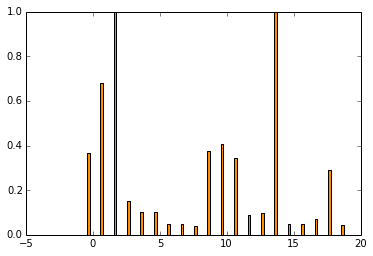

In [25]:
# Plot the feature score map
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

In [26]:
# Show feature score map
score_map = []
for x in range(len(scores)):
    x = column_titles[x], scores[x]
    score_map.append(x)
score_map_df = pd.DataFrame(score_map)
score_map_df = score_map_df.rename(columns = {0: 'FEATURE', 1 : 'SCORE'})
score_map_df

,FEATURE,SCORE
0,DOSAGE_TIME,0.366933
1,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.681914
2,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,1.000000
3,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,0.150863
4,GENDER_F,0.104017
5,GENDER_M,0.104017
6,ETHNICITY_NOT WHITE,0.048924
7,ETHNICITY_WHITE,0.048924
8,AGE_CAT_20s,0.039147
9,AGE_CAT_30s,0.376891


In [27]:
pvalue_map = []
for x in range(len(selector.pvalues_)):
    x = column_titles[x], selector.pvalues_[x]
    pvalue_map.append(x)
pvalue_df = pd.DataFrame(pvalue_map)
pvalue_df = pvalue_df.rename(columns = {0: 'FEATURE', 1 : 'P-VALUE'})
pvalue_df

,FEATURE,P-VALUE
0,DOSAGE_TIME,3.017394e-05
1,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,3.974567e-09
2,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,4.793859e-13
3,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,1.385077e-02
4,GENDER_F,5.231003e-02
5,GENDER_M,5.231003e-02
6,ETHNICITY_NOT WHITE,2.496241e-01
7,ETHNICITY_WHITE,2.496241e-01
8,AGE_CAT_20s,3.294098e-01
9,AGE_CAT_30s,2.274918e-05


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


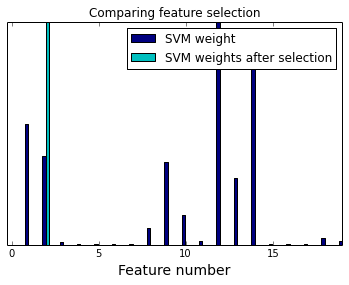

In [28]:
#SVM
from sklearn import datasets, svm

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

(982, 20)


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


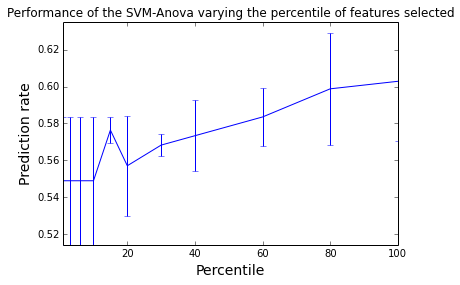

In [29]:
# SVM-ANOVA
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

print(X.shape)
y_list = y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
y_array = np.array(y_new)
y_array.shape

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y_array, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

Multivariate Analysis

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.65, 0.67, 0.66]
[0.6, 0.57, 0.59]
plotMat: [[0.65, 0.67, 0.66], [0.6, 0.57, 0.59]]
support: [159, 136]
Prediction accuracy:  0.627118644068


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


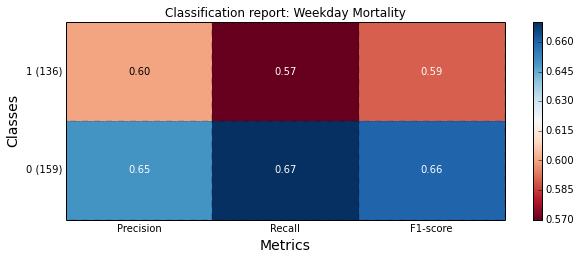

In [97]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_y, test_y = train_test_split(y, test_size=0.3, random_state=42)

y_list = test_y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
test_y = np.array(y_new)

# Fit
from sklearn.linear_model import LogisticRegression
lr_mn = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
lr_mn.fit(train_X, train_y)

# Predict
from sklearn import metrics, cross_validation
preds = cross_validation.cross_val_predict(lr_mn, test_X, test_y, cv=10)
ClassificationReport = metrics.classification_report(test_y, preds)

#Display
def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report: Weekday Mortality ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

plot_classification_report(ClassificationReport)
print ('Prediction accuracy: ', metrics.accuracy_score(test_y, preds))

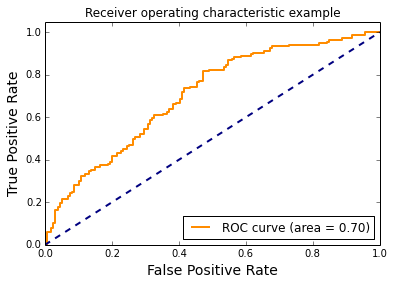

In [31]:
# Reciever Operating Characteristics (ROC)
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
random_state = np.random.RandomState(42)

# Convert to Binarize formatting
y = heparin_weekday[['EXPIRE_FLAG']].copy()
yy = y.applymap(int).as_matrix()
y = label_binarize(yy, classes=[0, 1])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
n_classes = y.shape[1]

# Learn to predict each class against the other
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state = random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

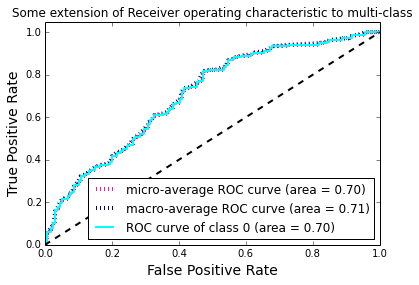

ROC AUC Score:  0.702044025157


In [32]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
print('ROC AUC Score: ', roc_auc_score(y_test, y_score))

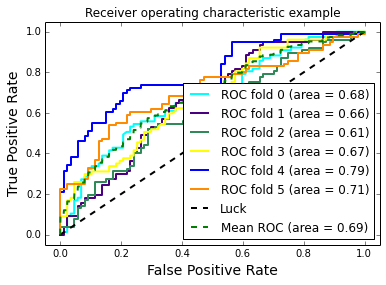

In [33]:
# Receiver Operating Characteristic (ROC) with cross validation
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 982) # (change based on size of data being run)

y = heparin_weekday[['EXPIRE_FLAG']].copy()
y = y.applymap(int) #change: make y values a one row matrix of ints
y_list = y['EXPIRE_FLAG'].tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i])
y = np.array(y_new)

X = X_cat_day.copy()
X = X.applymap(int).as_matrix() #change: make X values a matrix of ints
n_samples, n_features = X.shape 

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', 
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [34]:
mortality_day = pd.merge(pvalue_df, score_map_df, on = 'FEATURE')
mortality_day

,FEATURE,P-VALUE,SCORE
0,DOSAGE_TIME,3.017394e-05,0.366933
1,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,3.974567e-09,0.681914
2,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,4.793859e-13,1.000000
3,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,1.385077e-02,0.150863
4,GENDER_F,5.231003e-02,0.104017
5,GENDER_M,5.231003e-02,0.104017
6,ETHNICITY_NOT WHITE,2.496241e-01,0.048924
7,ETHNICITY_WHITE,2.496241e-01,0.048924
8,AGE_CAT_20s,3.294098e-01,0.039147
9,AGE_CAT_30s,2.274918e-05,0.376891


Probability Analysis

In [76]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
random_state = np.random.RandomState(42)

# Get Data
X = X_cat_day.copy()
X = X.applymap(int).as_matrix()

y_cat_day = heparin_weekday[['EXPIRE_FLAG']].copy()
yy = y_cat_day.applymap(int).as_matrix()
y = label_binarize(yy, classes=[0, 1])


# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state = random_state))
classifier.fit(X_train, y_train)
prob_mort_day = classifier.predict_proba(X_test).mean(axis=0).tolist()
prob_mort_day_df = pd.DataFrame(prob_mort_day)
prob_mort_day_df = prob_mort_day_df.rename(columns = {0: 'PROBABILITY'}, index = {0: 'ALIVE', 1: 'MORTALITY'})
prob_mort_day_df

,PROBABILITY
ALIVE,0.538916
MORTALITY,0.461084


2\. WEEKEND CATEGORIES : Target = MORTALITY

Univariate Analysis

In [32]:
X_cat_end = heparin_weekend[['ADMISSION_LOCATION', 'GENDER', 'ETHNICITY', 'AGE_CAT', 'DAY_NIGHT', 'DOSAGE_TIME', 'aPTT_CAT']].copy()
X_cat_end = pd.get_dummies(X_cat_end)
X = X_cat_end.as_matrix()

y_cat_end = heparin_weekend[['EXPIRE_FLAG']].copy()
y = y_cat_end.as_matrix()

column_titles = list(X_cat_end)
value_map = []
for value in range(len(column_titles)):
    x = column_titles[value], value
    value_map.append(x)
value_map

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])
X_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Container object of 20 artists>

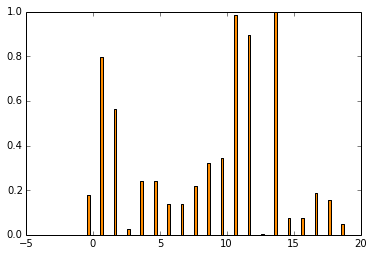

In [37]:
# Plot the feature score map
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

In [38]:
# Show feature score map
score_map = []
for x in range(len(scores)):
    x = column_titles[x], scores[x]
    score_map.append(x)
score_map_df = pd.DataFrame(score_map)
score_map_df = score_map_df.rename(columns = {0: 'FEATURE', 1 : 'SCORE'})
score_map_df

,FEATURE,SCORE
0,DOSAGE_TIME,0.177415
1,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.795912
2,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,0.563304
3,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,0.026195
4,GENDER_F,0.242384
5,GENDER_M,0.242384
6,ETHNICITY_NOT WHITE,0.135791
7,ETHNICITY_WHITE,0.135791
8,AGE_CAT_20s,0.219819
9,AGE_CAT_30s,0.323637


In [39]:
pvalue_map = []
for x in range(len(selector.pvalues_)):
    x = column_titles[x], selector.pvalues_[x]
    pvalue_map.append(x)
pvalue_df = pd.DataFrame(pvalue_map)
pvalue_df = pvalue_df.rename(columns = {0: 'FEATURE', 1 : 'P-VALUE'})
pvalue_df

,FEATURE,P-VALUE
0,DOSAGE_TIME,3.831796e-02
1,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,4.414862e-07
2,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,3.178428e-05
3,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,6.177880e-01
4,GENDER_F,1.160503e-02
5,GENDER_M,1.160503e-02
6,ETHNICITY_NOT WHITE,8.236777e-02
7,ETHNICITY_WHITE,8.236777e-02
8,AGE_CAT_20s,1.757198e-02
9,AGE_CAT_30s,2.605386e-03


In [ ]:
#SVM
from sklearn import datasets, svm

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# SVM-ANOVA
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

print(X.shape)
y_list = y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
y_array = np.array(y_new)
y_array.shape

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y_array, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

Multivariate Analysis

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.65, 0.63, 0.64]
[0.59, 0.61, 0.6]
plotMat: [[0.65, 0.63, 0.64], [0.59, 0.61, 0.6]]
support: [91, 80]
Prediction accuracy:  0.619883040936


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


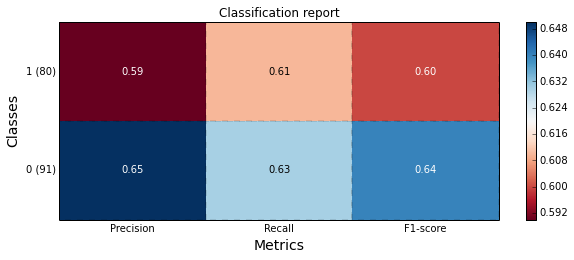

In [94]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_y, test_y = train_test_split(y, test_size=0.3, random_state=42)

y_list = test_y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
test_y = np.array(y_new)

# Fit
from sklearn.linear_model import LogisticRegression
lr_mn = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
lr_mn.fit(train_X, train_y)

# Predict
from sklearn import metrics, cross_validation
preds = cross_validation.cross_val_predict(lr_mn, test_X, test_y, cv=10)
ClassificationReport = metrics.classification_report(test_y, preds)

#Display
def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report: Weekend Mortality', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

plot_classification_report(ClassificationReport)
print ('Prediction accuracy: ', metrics.accuracy_score(test_y, preds))

In [ ]:
# Reciever Operating Characteristics (ROC)
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
random_state = np.random.RandomState(42)

# Convert to Binarize formatting
y = heparin_weekend[['EXPIRE_FLAG']].copy()
yy = y.applymap(int).as_matrix()
y = label_binarize(yy, classes=[0, 1])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
n_classes = y.shape[1]

# Learn to predict each class against the other
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state = random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
print('ROC AUC Score: ', roc_auc_score(y_test, y_score))

In [ ]:
# Receiver Operating Characteristic (ROC) with cross validation
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 982) # (change based on size of data being run)

y = heparin_weekend[['EXPIRE_FLAG']].copy()
y = y.applymap(int) #change: make y values a one row matrix of ints
y_list = y['EXPIRE_FLAG'].tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i])
y = np.array(y_new)

X = X_cat_end.copy()
X = X.applymap(int).as_matrix() #change: make X values a matrix of ints
n_samples, n_features = X.shape 

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', 
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
mortality_end = pd.merge(pvalue_df, score_map_df, on = 'FEATURE')
mortality_end

Probability Analysis

In [78]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
random_state = np.random.RandomState(42)

# Get Data
X = X_cat_end.copy()
X = X.applymap(int).as_matrix()

y_cat_end = heparin_weekend[['EXPIRE_FLAG']].copy()
yy = y_cat_end.applymap(int).as_matrix()
y = label_binarize(yy, classes=[0, 1])


# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state = random_state))
classifier.fit(X_train, y_train)
prob_mort_end = classifier.predict_proba(X_test).mean(axis=0).tolist()
prob_mort_end_df = pd.DataFrame(prob_mort_end)
prob_mort_end_df = prob_mort_end_df.rename(columns = {0: 'PROBABILITY'}, index = {0: 'ALIVE', 1: 'MORTALITY'})
prob_mort_end_df

,PROBABILITY
ALIVE,0.525809
MORTALITY,0.474191


3\. WEEKEND NUMERICAL : Target = MORTALITY

Univariate Analysis

In [148]:
X_num_day = heparin_weekday[['LOS', 'DOSAGE_TIME', 'MEASURE_TIME']].copy()
X_cat_day = heparin_weekday[['ADMISSION_LOCATION', 'GENDER', 'ETHNICITY', 'AGE_CAT', 'DAY_NIGHT', 'DOSAGE_TIME', 'aPTT_CAT']].copy()
X_cat_day = pd.get_dummies(X_cat_day)
X_num_day = pd.concat([X_num_day, X_cat_day], axis = 1)

X = X_num_day.as_matrix()

y_num_day = heparin_weekday[['EXPIRE_FLAG']].copy()
y = y_num_day.as_matrix()

column_titles = list(X_num_day)
value_map = []
for value in range(len(column_titles)):
    x = column_titles[value], value
    value_map.append(x)
value_map

[('LOS', 0),
 ('DOSAGE_TIME', 1),
 ('MEASURE_TIME', 2),
 ('DOSAGE_TIME', 3),
 ('ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE', 4),
 ('ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 5),
 ('ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI', 6),
 ('GENDER_F', 7),
 ('GENDER_M', 8),
 ('ETHNICITY_NOT WHITE', 9),
 ('ETHNICITY_WHITE', 10),
 ('AGE_CAT_20s', 11),
 ('AGE_CAT_30s', 12),
 ('AGE_CAT_40s', 13),
 ('AGE_CAT_50s', 14),
 ('AGE_CAT_89+', 15),
 ('AGE_CAT_Child', 16),
 ('AGE_CAT_Elderly', 17),
 ('DAY_NIGHT_DAY', 18),
 ('DAY_NIGHT_NIGHT', 19),
 ('aPTT_CAT_SUB-TH', 20),
 ('aPTT_CAT_SUPRA-TH', 21),
 ('aPTT_CAT_TH', 22)]

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Container object of 23 artists>

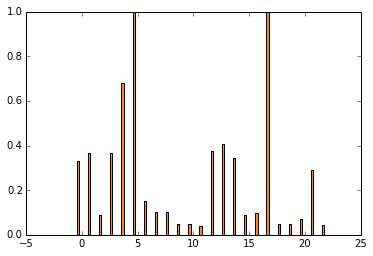

In [149]:
plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

# Plot the feature score map
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

In [150]:
# Show feature score map
score_map = []
for x in range(len(scores)):
    x = column_titles[x], scores[x]
    score_map.append(x)
score_map_df = pd.DataFrame(score_map)
score_map_df = score_map_df.rename(columns = {0: 'FEATURE', 1 : 'SCORE'})
score_map_df

,FEATURE,SCORE
0,LOS,0.328445
1,DOSAGE_TIME,0.366933
2,MEASURE_TIME,0.090407
3,DOSAGE_TIME,0.366933
4,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.681914
5,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,1.000000
6,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,0.150863
7,GENDER_F,0.104017
8,GENDER_M,0.104017
9,ETHNICITY_NOT WHITE,0.048924


In [151]:
pvalue_map = []
for x in range(len(selector.pvalues_)):
    x = column_titles[x], selector.pvalues_[x]
    pvalue_map.append(x)
pvalue_df = pd.DataFrame(pvalue_map)
pvalue_df = pvalue_df.rename(columns = {0: 'FEATURE', 1 : 'P-VALUE'})
pvalue_df

,FEATURE,P-VALUE
0,LOS,8.990378e-05
1,DOSAGE_TIME,3.017394e-05
2,MEASURE_TIME,7.695720e-02
3,DOSAGE_TIME,3.017394e-05
4,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,3.974567e-09
5,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,4.793859e-13
6,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,1.385077e-02
7,GENDER_F,5.231003e-02
8,GENDER_M,5.231003e-02
9,ETHNICITY_NOT WHITE,2.496241e-01


(982, 23)


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


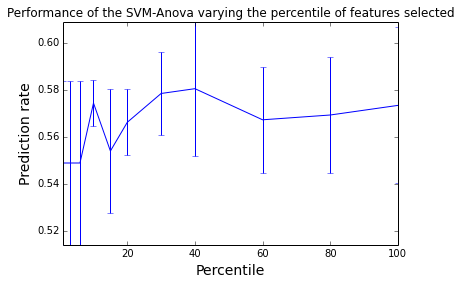

In [152]:
# SVM-ANOVA
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

print(X.shape)
y_list = y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
y_array = np.array(y_new)
y_array.shape

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y_array, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

Multivariate Analysis

4\. WEEKEND NUMERICAL : Target = MORTALITY

5\. WEEKDAY CATEGORIES : Target = aPTT_CAT

Univariate Analysis (sub-th)

In [110]:
data_manipulation = heparin_weekday[['ADMISSION_LOCATION', 'GENDER', 'ETHNICITY', 'AGE_CAT', 'DAY_NIGHT', 'EXPIRE_FLAG', 'aPTT_CAT']].copy()
data_manipulation['aPTT_CAT'] = data_manipulation['aPTT_CAT'].replace('SUB-TH', '1')
data_manipulation['aPTT_CAT'] = data_manipulation['aPTT_CAT'].replace('TH', '0')
data_manipulation['aPTT_CAT'] = data_manipulation['aPTT_CAT'].replace('SUPRA-TH', '0')

X_num_day = heparin_weekday[['AGE', 'LOS', 'DOSAGE_TIME', 'MEASURE_TIME']].copy()
X_num_day = X_num_day.applymap(int)

X_cat_day = data_manipulation[['ADMISSION_LOCATION', 'GENDER', 'ETHNICITY', 'EXPIRE_FLAG']].copy() # removed 'AGE_CAT', 'DAY_NIGHT',
X_cat_day['EXPIRE_FLAG'] = X_cat_day['EXPIRE_FLAG'].astype(int)
X_cat_day = pd.get_dummies(X_cat_day)
X_weekday = pd.concat([X_cat_day, X_num_day], axis = 1)

X = X_weekday.as_matrix()

y = data_manipulation[['aPTT_CAT']].copy()
y = y_cat_day.as_matrix()

column_titles = list(X_weekday)
value_map = []
for value in range(len(column_titles)):
    x = column_titles[value], value
    value_map.append(x)
value_map

[('EXPIRE_FLAG', 0),
 ('ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE', 1),
 ('ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 2),
 ('ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI', 3),
 ('GENDER_F', 4),
 ('GENDER_M', 5),
 ('ETHNICITY_NOT WHITE', 6),
 ('ETHNICITY_WHITE', 7),
 ('AGE', 8),
 ('LOS', 9),
 ('DOSAGE_TIME', 10),
 ('MEASURE_TIME', 11)]

In [111]:
plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])
X_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


<Container object of 12 artists>

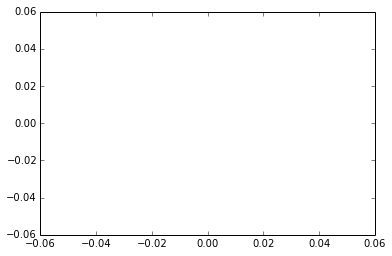

In [112]:
# Plot the feature score map
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

In [71]:
# Show feature score map
score_map = []
for x in range(len(scores)):
    x = column_titles[x], scores[x]
    score_map.append(x)
score_map_df = pd.DataFrame(score_map)
score_map_df = score_map_df.rename(columns = {0: 'FEATURE', 1 : 'SCORE'})
score_map_df

,FEATURE,SCORE
0,DOSAGE_TIME,0.491998
1,EXPIRE_FLAG,0.531278
2,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.248574
3,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,0.393641
4,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,1.000000
5,GENDER_F,0.710275
6,GENDER_M,0.710275
7,ETHNICITY_NOT WHITE,0.576504
8,ETHNICITY_WHITE,0.576504
9,AGE_CAT_20s,0.057036


In [63]:
pvalue_map = []
for x in range(len(selector.pvalues_)):
    x = column_titles[x], selector.pvalues_[x]
    pvalue_map.append(x)
pvalue_df = pd.DataFrame(pvalue_map)
pvalue_df = pvalue_df.rename(columns = {0: 'FEATURE', 1 : 'P-VALUE'})
pvalue_df

,FEATURE,P-VALUE
0,DOSAGE_TIME,0.157839
1,EXPIRE_FLAG,0.136208
2,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.393469
3,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,0.228298
4,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,0.023461
5,GENDER_F,0.069582
6,GENDER_M,0.069582
7,ETHNICITY_NOT WHITE,0.114947
8,ETHNICITY_WHITE,0.114947
9,AGE_CAT_20s,0.807330


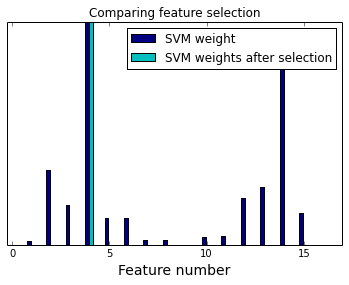

In [64]:
#SVC
from sklearn import datasets, svm

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [67]:
# SVM-ANOVA
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

y_list = y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
y_array = np.array(y_new)
y_array.shape

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y_array, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


ValueError: Found array with 0 feature(s) (shape=(655, 0)) while a minimum of 1 is required.

Multivariate Analysis

In [90]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_X, test_X = train_test_split(X, test_size=0.2, random_state=42)
train_y, test_y = train_test_split(y, test_size=0.2, random_state=42)

y_list = test_y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
test_y = np.array(y_new)

# Fit
from sklearn.linear_model import LogisticRegression
lr_mn = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
lr_mn.fit(train_X, train_y)

# Predict
from sklearn import metrics, cross_validation
preds = cross_validation.cross_val_predict(lr_mn, test_X, test_y, cv=10)
print ('Prediction accuracy: ', metrics.accuracy_score(test_y, preds))
print (metrics.classification_report(test_y, preds)) 

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Prediction accuracy:  0.53807106599
             precision    recall  f1-score   support

          0       0.46      0.31      0.37        86
          1       0.57      0.71      0.63       111

avg / total       0.52      0.54      0.52       197



In [113]:
# Reciever Operating Characteristics (ROC)
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
random_state = np.random.RandomState(42)

# Convert to Binarize formatting
y = data_manipulation[['aPTT_CAT']].copy()
yy = y.applymap(int).as_matrix()
y = label_binarize(yy, classes=[0, 1])
n_classes = y.shape[1]

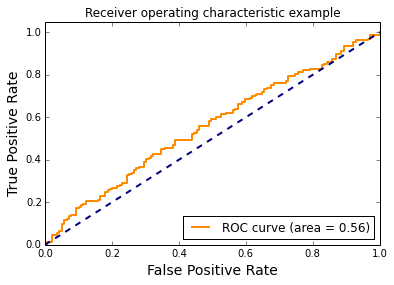

In [114]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
n_classes = y.shape[1]

# Learn to predict each class against the other
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state = random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
print('ROC AUC Score: ', roc_auc_score(y_test, y_score))

# Receiver Operating Characteristic (ROC) with cross validation
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 982) # (change based on size of data being run)

y = data_manipulation[['aPTT_CAT']].copy()
y = label_binarize(y, classes=['SUB-TH', 'TH', 'SUPRA-TH'])
#y = y.applymap(int) #change: make y values a one row matrix of ints
y_list = y['aPTT_CAT'].tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i])
y = np.array(y_new)

X = X_cat_day.copy()
X = X.applymap(int).as_matrix() #change: make X values a matrix of ints
n_samples, n_features = X.shape 

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', 
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()